<a href="https://colab.research.google.com/github/Yasserashraf1/AI-Salaries-Analysis-Project-Using-R-and-Tableau/blob/main/data_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning Notebook

This notebook performs comprehensive data cleaning on:
1. Weather Data (`weather_raw.csv`)
2. Traffic Data (`traffic_raw.csv`)

## Cleaning Steps:

### Weather Data:
- Handle missing values (imputation strategies)
- Remove duplicates
- Fix date/time formats (standardize to YYYY-MM-DD HH:MM)
- Handle outliers (temperature, humidity, wind speed)
- Standardize categorical variables (season, weather_condition)
- Validate ranges for each variable

### Traffic Data:
- Fix negative speeds and extreme vehicle counts
- Handle missing area/district values
- Standardize congestion_level categories
- Remove invalid records
- Handle extreme accident counts


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Raw Data


In [ ]:
# Load raw data
weather_df = pd.read_csv('Data/weather_raw.csv')
traffic_df = pd.read_csv('Data/traffic_raw.csv')

print("Weather Data Shape:", weather_df.shape)
print("Traffic Data Shape:", traffic_df.shape)
print("\nWeather Data Info:")
print(weather_df.info())
print("\nTraffic Data Info:")
print(traffic_df.info())


Weather Data Shape: (5050, 11)
Traffic Data Shape: (5040, 10)

Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weather_id         5025 non-null   float64
 1   date_time          4967 non-null   object 
 2   city               5025 non-null   object 
 3   season             4968 non-null   object 
 4   temperature_c      5026 non-null   float64
 5   humidity           5025 non-null   float64
 6   rain_mm            5025 non-null   float64
 7   wind_speed_kmh     5024 non-null   float64
 8   visibility_m       5025 non-null   float64
 9   weather_condition  5017 non-null   object 
 10  air_pressure_hpa   5025 non-null   float64
dtypes: float64(7), object(4)
memory usage: 434.1+ KB
None

Traffic Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5040 entries, 0 to 5039
Data columns (total 10 columns):
 

## 2. Weather Data Cleaning

### 2.1 Initial Data Overview


In [ ]:
# Create a copy for cleaning
weather_clean = weather_df.copy()

print("=== Weather Data Overview ===")
print(f"Total rows: {len(weather_clean)}")
print(f"\nMissing values per column:")
print(weather_clean.isnull().sum())
print(f"\nDuplicate rows: {weather_clean.duplicated().sum()}")
print(f"\nData types:")
print(weather_clean.dtypes)
print(f"\nSample data:")
print(weather_clean.head(10))


=== Weather Data Overview ===
Total rows: 5050

Missing values per column:
weather_id           25
date_time            83
city                 25
season               82
temperature_c        24
humidity             25
rain_mm              25
wind_speed_kmh       26
visibility_m         25
weather_condition    33
air_pressure_hpa     25
dtype: int64

Duplicate rows: 50

Data types:
weather_id           float64
date_time             object
city                  object
season                object
temperature_c        float64
humidity             float64
rain_mm              float64
wind_speed_kmh       float64
visibility_m         float64
weather_condition     object
air_pressure_hpa     float64
dtype: object

Sample data:
   weather_id          date_time    city  season  temperature_c  humidity  \
0      5001.0  2024-03-17T23:50Z  London  Spring          26.02      23.0   
1      5002.0    19/06/2024 10AM  London  Summer           0.53      60.0   
2      5003.0  2024-05-10T05:25Z  Lon

### 2.2 Remove Duplicates


In [ ]:
# Remove duplicate rows
duplicates_before = weather_clean.duplicated().sum()
weather_clean = weather_clean.drop_duplicates()
duplicates_removed = duplicates_before - weather_clean.duplicated().sum()

print(f"Duplicates removed: {duplicates_removed}")
print(f"Rows remaining: {len(weather_clean)}")


Duplicates removed: 50
Rows remaining: 5000


### 2.3 Fix Date/Time Formats (Standardize to YYYY-MM-DD HH:MM)


In [ ]:
def parse_datetime(date_str):
    """
    Parse various datetime formats and convert to YYYY-MM-DD HH:MM format
    Handles formats:
    - YYYY-MM-DD HH:MM
    - YYYY-MM-DDTHH:MMZ
    - DD/MM/YYYY HHAM/PM (e.g., 09/03/2024 05PM, 16/07/2024 05AM)
    """
    if pd.isna(date_str) or date_str == '' or str(date_str).strip() in ['Unknown', 'TBD', 'None']:
        return None

    date_str = str(date_str).strip()

    # Try different formats
    formats = [
        '%Y-%m-%d %H:%M',           # 2024-03-07 12:54
        '%Y-%m-%dT%H:%MZ',          # 2024-03-07T12:54Z
        '%d/%m/%Y %I%p',            # 09/03/2024 05PM, 12/07/2024 12PM
        '%d/%m/%Y %I%M%p',          # 09/03/2024 05:30PM (if minutes included)
    ]

    for fmt in formats:
        try:
            dt = datetime.strptime(date_str, fmt)
            return dt.strftime('%Y-%m-%d %H:%M')
        except:
            continue

    # If all formats fail, return None
    return None

# Apply datetime parsing
weather_clean['date_time'] = weather_clean['date_time'].apply(parse_datetime)

# Count invalid dates
invalid_dates = weather_clean['date_time'].isnull().sum()
print(f"Invalid dates (will be handled): {invalid_dates}")

# Show sample of converted dates
print("\nSample converted dates:")
print(weather_clean[['date_time']].head(10))


Invalid dates (will be handled): 183

Sample converted dates:
          date_time
0  2024-03-17 23:50
1  2024-06-19 10:00
2  2024-05-10 05:25
3  2024-04-23 07:50
4  2024-05-18 09:00
5  2024-05-20 06:02
6  2024-01-09 17:09
7  2024-01-18 11:24
8  2024-07-07 19:00
9  2024-06-04 19:18


### 2.4 Handle Outliers

#### Temperature Outliers


In [ ]:
# Define valid ranges for weather variables
TEMPERATURE_MIN = -10  # Reasonable minimum for London
TEMPERATURE_MAX = 40   # Reasonable maximum for London
HUMIDITY_MIN = 0
HUMIDITY_MAX = 100
WIND_SPEED_MIN = 0
WIND_SPEED_MAX = 100  # Extreme but possible
VISIBILITY_MIN = 0
VISIBILITY_MAX = 20000  # Reasonable max visibility
RAIN_MIN = 0
RAIN_MAX = 100  # Extreme rainfall
AIR_PRESSURE_MIN = 950
AIR_PRESSURE_MAX = 1050

# Handle temperature outliers
temp_outliers_before = ((weather_clean['temperature_c'] < TEMPERATURE_MIN) |
                        (weather_clean['temperature_c'] > TEMPERATURE_MAX)).sum()
print(f"Temperature outliers found: {temp_outliers_before}")

# Clip outliers to valid range
weather_clean['temperature_c'] = weather_clean['temperature_c'].clip(
    lower=TEMPERATURE_MIN, upper=TEMPERATURE_MAX
)

print(f"Temperature statistics after clipping:")
print(weather_clean['temperature_c'].describe())


Temperature outliers found: 20
Temperature statistics after clipping:
count    4976.000000
mean       15.003726
std        11.551481
min        -4.990000
25%         5.020000
50%        14.950000
75%        25.010000
max        40.000000
Name: temperature_c, dtype: float64


#### Humidity Outliers


In [ ]:
# Handle humidity outliers
humidity_outliers_before = ((weather_clean['humidity'] < HUMIDITY_MIN) |
                            (weather_clean['humidity'] > HUMIDITY_MAX)).sum()
print(f"Humidity outliers found: {humidity_outliers_before}")

# Clip outliers to valid range
weather_clean['humidity'] = weather_clean['humidity'].clip(
    lower=HUMIDITY_MIN, upper=HUMIDITY_MAX
)

print(f"Humidity statistics after clipping:")
print(weather_clean['humidity'].describe())


Humidity outliers found: 20
Humidity statistics after clipping:
count    4975.000000
mean       59.271759
std        23.678463
min         0.000000
25%        39.000000
50%        59.000000
75%        80.000000
max        99.000000
Name: humidity, dtype: float64


#### Wind Speed Outliers


In [ ]:
# Handle wind speed outliers
wind_outliers_before = ((weather_clean['wind_speed_kmh'] < WIND_SPEED_MIN) |
                        (weather_clean['wind_speed_kmh'] > WIND_SPEED_MAX)).sum()
print(f"Wind speed outliers found: {wind_outliers_before}")

# Clip outliers to valid range
weather_clean['wind_speed_kmh'] = weather_clean['wind_speed_kmh'].clip(
    lower=WIND_SPEED_MIN, upper=WIND_SPEED_MAX
)

print(f"Wind speed statistics after clipping:")
print(weather_clean['wind_speed_kmh'].describe())


Wind speed outliers found: 10
Wind speed statistics after clipping:
count    4975.000000
mean       39.969148
std        23.178967
min         0.040000
25%        20.160000
50%        39.460000
75%        60.260000
max       100.000000
Name: wind_speed_kmh, dtype: float64


#### Other Variable Outliers (Rain, Visibility, Air Pressure)


In [ ]:
# Handle rain outliers
rain_outliers_before = ((weather_clean['rain_mm'] < RAIN_MIN) |
                         (weather_clean['rain_mm'] > RAIN_MAX)).sum()
weather_clean['rain_mm'] = weather_clean['rain_mm'].clip(lower=RAIN_MIN, upper=RAIN_MAX)
print(f"Rain outliers clipped: {rain_outliers_before}")

# Handle visibility outliers
visibility_outliers_before = ((weather_clean['visibility_m'] < VISIBILITY_MIN) |
                               (weather_clean['visibility_m'] > VISIBILITY_MAX)).sum()
weather_clean['visibility_m'] = weather_clean['visibility_m'].clip(
    lower=VISIBILITY_MIN, upper=VISIBILITY_MAX
)
print(f"Visibility outliers clipped: {visibility_outliers_before}")

# Handle air pressure outliers
pressure_outliers_before = ((weather_clean['air_pressure_hpa'] < AIR_PRESSURE_MIN) |
                             (weather_clean['air_pressure_hpa'] > AIR_PRESSURE_MAX)).sum()
weather_clean['air_pressure_hpa'] = weather_clean['air_pressure_hpa'].clip(
    lower=AIR_PRESSURE_MIN, upper=AIR_PRESSURE_MAX
)
print(f"Air pressure outliers clipped: {pressure_outliers_before}")


Rain outliers clipped: 9
Visibility outliers clipped: 10
Air pressure outliers clipped: 11


### 2.5 Standardize Categorical Variables

#### Standardize Season


In [ ]:
def infer_season_from_date(date_str):
    """Infer season from date if missing or invalid"""
    if pd.isna(date_str):
        return None

    try:
        dt = pd.to_datetime(date_str, format='%Y-%m-%d %H:%M', errors='coerce')
        if pd.isna(dt):
            return None
        month = dt.month
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'
    except:
        return None

# Valid seasons
valid_seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# Standardize season
print("Season values before standardization:")
print(weather_clean['season'].value_counts())

# Replace invalid seasons with None
weather_clean['season'] = weather_clean['season'].apply(
    lambda x: x if x in valid_seasons else None
)

# Infer season from date_time for missing/invalid values
mask_missing_season = weather_clean['season'].isnull()
weather_clean.loc[mask_missing_season, 'season'] = weather_clean.loc[mask_missing_season, 'date_time'].apply(
    infer_season_from_date
)

print("\nSeason values after standardization:")
print(weather_clean['season'].value_counts())
print(f"\nMissing seasons remaining: {weather_clean['season'].isnull().sum()}")


Season values before standardization:
season
Spring    2113
Winter    1401
Summer    1130
Autumn     254
HOT         20
Name: count, dtype: int64

Season values after standardization:
season
Spring    2135
Winter    1411
Summer    1139
Autumn     254
Name: count, dtype: int64

Missing seasons remaining: 61


#### Standardize Weather Condition


In [ ]:
# Valid weather conditions
valid_weather_conditions = ['Clear', 'Rain', 'Fog', 'Storm', 'Snow']

# Standardize weather_condition
print("Weather condition values before standardization:")
print(weather_clean['weather_condition'].value_counts())

# Replace invalid weather conditions with None
weather_clean['weather_condition'] = weather_clean['weather_condition'].apply(
    lambda x: x if x in valid_weather_conditions else None
)

print("\nWeather condition values after standardization:")
print(weather_clean['weather_condition'].value_counts())
print(f"\nMissing weather conditions: {weather_clean['weather_condition'].isnull().sum()}")


Weather condition values before standardization:
weather_condition
Storm      1011
Fog        1002
Rain        991
Snow        970
Clear       963
BAD          13
CLR           7
Unknown       6
RN            4
Name: count, dtype: int64

Weather condition values after standardization:
weather_condition
Storm    1011
Fog      1002
Rain      991
Snow      970
Clear     963
Name: count, dtype: int64

Missing weather conditions: 63


### 2.6 Handle Missing Values (Imputation Strategies)


In [ ]:
print("Missing values before imputation:")
print(weather_clean.isnull().sum())

# Imputation strategies:
# - Numeric columns: Use median (more robust to outliers)
# - Categorical columns: Use mode
# - date_time: Drop rows with missing dates (critical for time series)
# - season: Already handled by inference from date

# Drop rows with missing date_time (critical field)
rows_before = len(weather_clean)
weather_clean = weather_clean.dropna(subset=['date_time'])
rows_dropped = rows_before - len(weather_clean)
print(f"\nDropped {rows_dropped} rows with missing date_time")

# Impute numeric columns with median
numeric_cols = ['weather_id', 'temperature_c', 'humidity', 'rain_mm', 'wind_speed_kmh',
                'visibility_m', 'air_pressure_hpa']

for col in numeric_cols:
    if col in weather_clean.columns and weather_clean[col].isnull().sum() > 0:
        median_val = weather_clean[col].median()
        weather_clean[col].fillna(median_val, inplace=True)
        print(f"Imputed {col} with median: {median_val:.2f}")

# Impute categorical columns with mode
categorical_cols = ['city', 'season', 'weather_condition']

for col in categorical_cols:
    if col in weather_clean.columns and weather_clean[col].isnull().sum() > 0:
        mode_val = weather_clean[col].mode()[0] if len(weather_clean[col].mode()) > 0 else None
        if mode_val:
            weather_clean[col].fillna(mode_val, inplace=True)
            print(f"Imputed {col} with mode: {mode_val}")

print("\nMissing values after imputation:")
print(weather_clean.isnull().sum())


Missing values before imputation:
weather_id            25
date_time            183
city                  25
season                61
temperature_c         24
humidity              25
rain_mm               25
wind_speed_kmh        25
visibility_m          25
weather_condition     63
air_pressure_hpa      25
dtype: int64

Dropped 183 rows with missing date_time
Imputed weather_id with median: 7492.50
Imputed temperature_c with median: 14.99
Imputed humidity with median: 59.00
Imputed rain_mm with median: 25.39
Imputed wind_speed_kmh with median: 39.55
Imputed visibility_m with median: 5030.00
Imputed air_pressure_hpa with median: 997.65
Imputed city with mode: London
Imputed weather_condition with mode: Storm

Missing values after imputation:
weather_id           0
date_time            0
city                 0
season               0
temperature_c        0
humidity             0
rain_mm              0
wind_speed_kmh       0
visibility_m         0
weather_condition    0
air_pressure_hpa  

### 2.7 Validate Ranges for Each Variable


In [ ]:
# Final validation of ranges
print("=== Final Range Validation ===")

validation_results = {
    'temperature_c': (weather_clean['temperature_c'].between(TEMPERATURE_MIN, TEMPERATURE_MAX).all(),
                      f"{TEMPERATURE_MIN} to {TEMPERATURE_MAX}"),
    'humidity': (weather_clean['humidity'].between(HUMIDITY_MIN, HUMIDITY_MAX).all(),
                 f"{HUMIDITY_MIN} to {HUMIDITY_MAX}"),
    'wind_speed_kmh': (weather_clean['wind_speed_kmh'].between(WIND_SPEED_MIN, WIND_SPEED_MAX).all(),
                       f"{WIND_SPEED_MIN} to {WIND_SPEED_MAX}"),
    'rain_mm': (weather_clean['rain_mm'].between(RAIN_MIN, RAIN_MAX).all(),
                f"{RAIN_MIN} to {RAIN_MAX}"),
    'visibility_m': (weather_clean['visibility_m'].between(VISIBILITY_MIN, VISIBILITY_MAX).all(),
                     f"{VISIBILITY_MIN} to {VISIBILITY_MAX}"),
    'air_pressure_hpa': (weather_clean['air_pressure_hpa'].between(AIR_PRESSURE_MIN, AIR_PRESSURE_MAX).all(),
                         f"{AIR_PRESSURE_MIN} to {AIR_PRESSURE_MAX}"),
}

for col, (is_valid, valid_range) in validation_results.items():
    status = "✓ PASS" if is_valid else "✗ FAIL"
    print(f"{col:20s} {status:10s} Range: {valid_range}")

# Validate categorical variables
print(f"\nSeason values: {sorted(weather_clean['season'].unique())}")
print(f"Weather condition values: {sorted(weather_clean['weather_condition'].unique())}")

print(f"\nFinal weather data shape: {weather_clean.shape}")
print(f"Final missing values: {weather_clean.isnull().sum().sum()}")
print(f"\nMissing values per column:")
print(weather_clean.isnull().sum())


=== Final Range Validation ===
temperature_c        ✓ PASS     Range: -10 to 40
humidity             ✓ PASS     Range: 0 to 100
wind_speed_kmh       ✓ PASS     Range: 0 to 100
rain_mm              ✓ PASS     Range: 0 to 100
visibility_m         ✓ PASS     Range: 0 to 20000
air_pressure_hpa     ✓ PASS     Range: 950 to 1050

Season values: ['Autumn', 'Spring', 'Summer', 'Winter']
Weather condition values: ['Clear', 'Fog', 'Rain', 'Snow', 'Storm']

Final weather data shape: (4817, 11)
Final missing values: 0

Missing values per column:
weather_id           0
date_time            0
city                 0
season               0
temperature_c        0
humidity             0
rain_mm              0
wind_speed_kmh       0
visibility_m         0
weather_condition    0
air_pressure_hpa     0
dtype: int64


In [ ]:
weather_clean['date_time'] = pd.to_datetime(weather_clean['date_time'], format='%Y-%m-%d %H:%M')

In [ ]:
object_weather_col=weather_clean.select_dtypes(include=['object']).columns.tolist()
for col in object_weather_col:
    weather_clean[col]=weather_clean[col].astype('category')

In [ ]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4817 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   weather_id         4817 non-null   float64       
 1   date_time          4817 non-null   datetime64[ns]
 2   city               4817 non-null   category      
 3   season             4817 non-null   category      
 4   temperature_c      4817 non-null   float64       
 5   humidity           4817 non-null   float64       
 6   rain_mm            4817 non-null   float64       
 7   wind_speed_kmh     4817 non-null   float64       
 8   visibility_m       4817 non-null   float64       
 9   weather_condition  4817 non-null   category      
 10  air_pressure_hpa   4817 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(7)
memory usage: 353.3 KB


## 3. Traffic Data Cleaning

### 3.1 Initial Data Overview


In [ ]:
# Create a copy for cleaning
traffic_clean = traffic_df.copy()

print("=== Traffic Data Overview ===")
print(f"Total rows: {len(traffic_clean)}")
print(f"\nMissing values per column:")
print(traffic_clean.isnull().sum())
print(f"\nDuplicate rows: {traffic_clean.duplicated().sum()}")
print(f"\nData types:")
print(traffic_clean.dtypes)
print(f"\nSample data:")
print(traffic_clean.head(10))


=== Traffic Data Overview ===
Total rows: 5040

Missing values per column:
traffic_id          20
date_time           73
city                20
area                20
vehicle_count       20
avg_speed_kmh       20
accident_count      19
congestion_level    21
road_condition      24
visibility_m        20
dtype: int64

Duplicate rows: 40

Data types:
traffic_id          float64
date_time            object
city                 object
area                 object
vehicle_count       float64
avg_speed_kmh       float64
accident_count      float64
congestion_level     object
road_condition       object
visibility_m        float64
dtype: object

Sample data:
   traffic_id          date_time    city         area  vehicle_count  \
0      9001.0   2024-03-07 12:54  London  Westminster         1852.0   
1      9002.0    09/03/2024 05PM  London  Hammersmith         3021.0   
2      9003.0   2024-05-14 22:05  London      Hackney         4343.0   
3      9004.0  2024-07-07T17:17Z  London    Islington

### 3.2 Remove Duplicates


In [ ]:
# Remove duplicate rows
duplicates_before = traffic_clean.duplicated().sum()
traffic_clean = traffic_clean.drop_duplicates()
duplicates_removed = duplicates_before - traffic_clean.duplicated().sum()

print(f"Duplicates removed: {duplicates_removed}")
print(f"Rows remaining: {len(traffic_clean)}")


Duplicates removed: 40
Rows remaining: 5000


### 3.3 Fix Date/Time Formats (Standardize to YYYY-MM-DD HH:MM)


In [ ]:
# Use the same datetime parsing function
traffic_clean['date_time'] = traffic_clean['date_time'].apply(parse_datetime)

# Count invalid dates
invalid_dates = traffic_clean['date_time'].isnull().sum()
print(f"Invalid dates found: {invalid_dates}")

# Show sample of converted dates
print("\nSample converted dates:")
print(traffic_clean[['date_time']].head(10))


Invalid dates found: 158

Sample converted dates:
          date_time
0  2024-03-07 12:54
1  2024-03-09 17:00
2  2024-05-14 22:05
3  2024-07-07 17:17
4  2024-05-11 09:35
5  2024-07-12 12:00
6  2024-04-08 15:00
7  2024-06-26 15:15
8  2024-03-28 20:59
9  2024-07-16 05:00


### 3.4 Fix Negative Speeds and Extreme Vehicle Counts


In [ ]:
# Define valid ranges for traffic variables
SPEED_MIN = 0
SPEED_MAX = 130  # UK motorway speed limit + some buffer
VEHICLE_COUNT_MIN = 0
VEHICLE_COUNT_MAX = 10000  # Reasonable maximum for a single measurement
ACCIDENT_COUNT_MIN = 0
ACCIDENT_COUNT_MAX = 15  # Extreme but possible
VISIBILITY_TRAFFIC_MIN = 0
VISIBILITY_TRAFFIC_MAX = 20000

# Fix negative speeds
negative_speeds = (traffic_clean['avg_speed_kmh'] < SPEED_MIN).sum()
print(f"Negative speeds found: {negative_speeds}")

# Clip speeds to valid range
traffic_clean['avg_speed_kmh'] = traffic_clean['avg_speed_kmh'].clip(
    lower=SPEED_MIN, upper=SPEED_MAX
)

# Fix extreme vehicle counts
extreme_vehicles = (traffic_clean['vehicle_count'] > VEHICLE_COUNT_MAX).sum()
print(f"Extreme vehicle counts (> {VEHICLE_COUNT_MAX}) found: {extreme_vehicles}")

# Clip vehicle counts to valid range
traffic_clean['vehicle_count'] = traffic_clean['vehicle_count'].clip(
    lower=VEHICLE_COUNT_MIN, upper=VEHICLE_COUNT_MAX
)

print(f"\nSpeed statistics after cleaning:")
print(traffic_clean['avg_speed_kmh'].describe())
print(f"\nVehicle count statistics after cleaning:")
print(traffic_clean['vehicle_count'].describe())


Negative speeds found: 20
Extreme vehicle counts (> 10000) found: 20

Speed statistics after cleaning:
count    4980.000000
mean       62.335926
std        33.576650
min         0.000000
25%        32.952500
50%        62.220000
75%        91.635000
max       120.000000
Name: avg_speed_kmh, dtype: float64

Vehicle count statistics after cleaning:
count     4980.000000
mean      2503.750201
std       1520.121658
min          0.000000
25%       1243.000000
50%       2473.500000
75%       3746.750000
max      10000.000000
Name: vehicle_count, dtype: float64


### 3.5 Handle Missing Area/District Values


In [ ]:
# Valid areas/districts in London
valid_areas = ['Camden', 'Chelsea', 'Islington', 'Kensington',
               'Southwark', 'Westminster', 'Hammersmith', 'Hackney']

print("Area values before cleaning:")
print(traffic_clean['area'].value_counts())
print(f"\nMissing areas: {traffic_clean['area'].isnull().sum()}")

# Replace invalid areas with None
traffic_clean['area'] = traffic_clean['area'].apply(
    lambda x: x if x in valid_areas else None
)

# Impute missing areas with mode (most common area)
if traffic_clean['area'].isnull().sum() > 0:
    mode_area = traffic_clean['area'].mode()[0] if len(traffic_clean['area'].mode()) > 0 else None
    if mode_area:
        traffic_clean['area'].fillna(mode_area, inplace=True)
        print(f"Imputed missing areas with mode: {mode_area}")

print("\nArea values after cleaning:")
print(traffic_clean['area'].value_counts())
print(f"\nMissing areas remaining: {traffic_clean['area'].isnull().sum()}")


Area values before cleaning:
area
Camden         670
Westminster    664
Kensington     622
Hammersmith    621
Chelsea        615
Southwark      607
Hackney        595
Islington      586
Name: count, dtype: int64

Missing areas: 20
Imputed missing areas with mode: Camden

Area values after cleaning:
area
Camden         690
Westminster    664
Kensington     622
Hammersmith    621
Chelsea        615
Southwark      607
Hackney        595
Islington      586
Name: count, dtype: int64

Missing areas remaining: 0


### 3.6 Standardize Congestion Level Categories


In [ ]:
# Valid congestion levels
valid_congestion_levels = ['Low', 'Medium', 'High']

print("Congestion level values before standardization:")
print(traffic_clean['congestion_level'].value_counts())

# Standardize congestion_level
traffic_clean['congestion_level'] = traffic_clean['congestion_level'].apply(
    lambda x: x if x in valid_congestion_levels else None
)

# Impute missing congestion_level with mode
if traffic_clean['congestion_level'].isnull().sum() > 0:
    mode_congestion = traffic_clean['congestion_level'].mode()[0] if len(traffic_clean['congestion_level'].mode()) > 0 else None
    if mode_congestion:
        traffic_clean['congestion_level'].fillna(mode_congestion, inplace=True)
        print(f"Imputed missing congestion_level with mode: {mode_congestion}")

print("\nCongestion level values after standardization:")
print(traffic_clean['congestion_level'].value_counts())
print(f"\nMissing congestion levels remaining: {traffic_clean['congestion_level'].isnull().sum()}")


Congestion level values before standardization:
congestion_level
Medium     1693
Low        1653
High       1604
Unknown      10
MED           8
HIGG          7
LOWW          4
Name: count, dtype: int64
Imputed missing congestion_level with mode: Medium

Congestion level values after standardization:
congestion_level
Medium    1743
Low       1653
High      1604
Name: count, dtype: int64

Missing congestion levels remaining: 0


### 3.7 Standardize Road Condition Categories


In [ ]:
# Valid road conditions
valid_road_conditions = ['Dry', 'Wet', 'Snowy', 'Damaged']

print("Road condition values before standardization:")
print(traffic_clean['road_condition'].value_counts())

# Standardize road_condition
traffic_clean['road_condition'] = traffic_clean['road_condition'].apply(
    lambda x: x if x in valid_road_conditions else None
)

# Impute missing road_condition with mode
if traffic_clean['road_condition'].isnull().sum() > 0:
    mode_road = traffic_clean['road_condition'].mode()[0] if len(traffic_clean['road_condition'].mode()) > 0 else None
    if mode_road:
        traffic_clean['road_condition'].fillna(mode_road, inplace=True)
        print(f"Imputed missing road_condition with mode: {mode_road}")

print("\nRoad condition values after standardization:")
print(traffic_clean['road_condition'].value_counts())
print(f"\nMissing road conditions remaining: {traffic_clean['road_condition'].isnull().sum()}")


Road condition values before standardization:
road_condition
Dry        1264
Snowy      1243
Damaged    1230
Wet        1223
Invalid       9
Broken        5
Bad           2
Name: count, dtype: int64
Imputed missing road_condition with mode: Dry

Road condition values after standardization:
road_condition
Dry        1304
Snowy      1243
Damaged    1230
Wet        1223
Name: count, dtype: int64

Missing road conditions remaining: 0


### 3.8 Handle Extreme Accident Counts


In [ ]:
# Handle extreme accident counts
extreme_accidents = (traffic_clean['accident_count'] > ACCIDENT_COUNT_MAX).sum()
print(f"Extreme accident counts (> {ACCIDENT_COUNT_MAX}) found: {extreme_accidents}")

# Clip accident counts to valid range
traffic_clean['accident_count'] = traffic_clean['accident_count'].clip(
    lower=ACCIDENT_COUNT_MIN, upper=ACCIDENT_COUNT_MAX
)

print(f"\nAccident count statistics after cleaning:")
print(traffic_clean['accident_count'].describe())
print(f"\nAccident count distribution:")
print(traffic_clean['accident_count'].value_counts().sort_index())


Extreme accident counts (> 15) found: 10

Accident count statistics after cleaning:
count    4981.000000
mean        4.485244
std         2.944062
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        15.000000
Name: accident_count, dtype: float64

Accident count distribution:
accident_count
0.0     527
1.0     495
2.0     513
3.0     514
4.0     470
5.0     485
6.0     509
7.0     440
8.0     473
9.0     545
15.0     10
Name: count, dtype: int64


### 3.9 Handle Missing Values and Remove Invalid Records


In [ ]:
print("Missing values before imputation:")
print(traffic_clean.isnull().sum())

# Drop rows with missing date_time (critical field)
rows_before = len(traffic_clean)
traffic_clean = traffic_clean.dropna(subset=['date_time'])
rows_dropped = rows_before - len(traffic_clean)
print(f"\nDropped {rows_dropped} rows with missing date_time")

# Impute numeric columns with median
numeric_cols = ['traffic_id', 'vehicle_count', 'avg_speed_kmh', 'accident_count', 'visibility_m']

for col in numeric_cols:
    if col in traffic_clean.columns and traffic_clean[col].isnull().sum() > 0:
        median_val = traffic_clean[col].median()
        traffic_clean[col].fillna(median_val, inplace=True)
        print(f"Imputed {col} with median: {median_val:.2f}")

# Impute categorical columns with mode
categorical_cols = ['city']

for col in categorical_cols:
    if col in traffic_clean.columns and traffic_clean[col].isnull().sum() > 0:
        mode_val = traffic_clean[col].mode()[0] if len(traffic_clean[col].mode()) > 0 else None
        if mode_val:
            traffic_clean[col].fillna(mode_val, inplace=True)
            print(f"Imputed {col} with mode: {mode_val}")

# Handle visibility outliers
traffic_clean['visibility_m'] = traffic_clean['visibility_m'].clip(
    lower=VISIBILITY_TRAFFIC_MIN, upper=VISIBILITY_TRAFFIC_MAX
)

print("\nMissing values after imputation:")
print(traffic_clean.isnull().sum())


Missing values before imputation:
traffic_id           20
date_time           158
city                 20
area                  0
vehicle_count        20
avg_speed_kmh        20
accident_count       19
congestion_level      0
road_condition        0
visibility_m         20
dtype: int64

Dropped 158 rows with missing date_time
Imputed traffic_id with median: 11497.50
Imputed vehicle_count with median: 2468.00
Imputed avg_speed_kmh with median: 62.30
Imputed accident_count with median: 4.00
Imputed visibility_m with median: 7552.00
Imputed city with mode: London

Missing values after imputation:
traffic_id          0
date_time           0
city                0
area                0
vehicle_count       0
avg_speed_kmh       0
accident_count      0
congestion_level    0
road_condition      0
visibility_m        0
dtype: int64


### 3.10 Remove Invalid Records

Remove records that still have critical missing values or invalid data.


In [ ]:
# Remove records with missing critical fields (if any remain after imputation)
rows_before = len(traffic_clean)
traffic_clean = traffic_clean.dropna(subset=['area', 'congestion_level', 'road_condition'])
rows_dropped = rows_before - len(traffic_clean)
print(f"Dropped {rows_dropped} rows with missing critical fields")

print(f"\nFinal traffic data shape: {traffic_clean.shape}")
print(f"Final missing values: {traffic_clean.isnull().sum().sum()}")
print(f"\nMissing values per column:")
print(traffic_clean.isnull().sum())
print(f"\nFinal data summary:")
print(traffic_clean.describe())


Dropped 0 rows with missing critical fields

Final traffic data shape: (4842, 10)
Final missing values: 0

Missing values per column:
traffic_id          0
date_time           0
city                0
area                0
vehicle_count       0
avg_speed_kmh       0
accident_count      0
congestion_level    0
road_condition      0
visibility_m        0
dtype: int64

Final data summary:
         traffic_id  vehicle_count  avg_speed_kmh  accident_count  \
count   4842.000000    4842.000000    4842.000000     4842.000000   
mean   11503.023337    2503.041718      62.299851        4.484304   
std     1440.824555    1516.997608      33.516816        2.939074   
min     9001.000000       3.000000       0.000000        0.000000   
25%    10257.250000    1246.000000      32.992500        2.000000   
50%    11497.500000    2468.000000      62.300000        4.000000   
75%    12751.750000    3739.500000      91.450000        7.000000   
max    14000.000000   10000.000000     120.000000       15.0

In [ ]:
traffic_clean['date_time'] = pd.to_datetime(traffic_clean['date_time'], format='%Y-%m-%d %H:%M')

In [ ]:
object_traffic_col=traffic_clean.select_dtypes(include=['object']).columns.tolist()
for col in object_traffic_col:
    traffic_clean[col]=traffic_clean[col].astype('category')

In [ ]:
traffic_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4842 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   traffic_id        4842 non-null   float64       
 1   date_time         4842 non-null   datetime64[ns]
 2   city              4842 non-null   category      
 3   area              4842 non-null   category      
 4   vehicle_count     4842 non-null   float64       
 5   avg_speed_kmh     4842 non-null   float64       
 6   accident_count    4842 non-null   float64       
 7   congestion_level  4842 non-null   category      
 8   road_condition    4842 non-null   category      
 9   visibility_m      4842 non-null   float64       
dtypes: category(4), datetime64[ns](1), float64(5)
memory usage: 284.5 KB


## 4. Final Data Validation and Summary


In [ ]:
print("=" * 60)
print("CLEANING SUMMARY")
print("=" * 60)

print("\n=== WEATHER DATA ===")
print(f"Original rows: {len(weather_df)}")
print(f"Cleaned rows: {len(weather_clean)}")
print(f"Rows removed: {len(weather_df) - len(weather_clean)}")
print(f"Missing values: {weather_clean.isnull().sum().sum()}")
print(f"Duplicates: {weather_clean.duplicated().sum()}")

print("\n=== TRAFFIC DATA ===")
print(f"Original rows: {len(traffic_df)}")
print(f"Cleaned rows: {len(traffic_clean)}")
print(f"Rows removed: {len(traffic_df) - len(traffic_clean)}")
print(f"Missing values: {traffic_clean.isnull().sum().sum()}")
print(f"Duplicates: {traffic_clean.duplicated().sum()}")

print("\n=== DATA QUALITY CHECKS ===")
print("\nWeather Data:")
print(f"  - Date format standardized: ✓")
print(f"  - Temperature range: {weather_clean['temperature_c'].min():.2f} to {weather_clean['temperature_c'].max():.2f}°C")
print(f"  - Humidity range: {weather_clean['humidity'].min():.0f} to {weather_clean['humidity'].max():.0f}%")
print(f"  - Wind speed range: {weather_clean['wind_speed_kmh'].min():.2f} to {weather_clean['wind_speed_kmh'].max():.2f} km/h")
print(f"  - Valid seasons: {sorted(weather_clean['season'].unique())}")
print(f"  - Valid weather conditions: {sorted(weather_clean['weather_condition'].unique())}")

print("\nTraffic Data:")
print(f"  - Date format standardized: ✓")
print(f"  - Speed range: {traffic_clean['avg_speed_kmh'].min():.2f} to {traffic_clean['avg_speed_kmh'].max():.2f} km/h")
print(f"  - Vehicle count range: {traffic_clean['vehicle_count'].min():.0f} to {traffic_clean['vehicle_count'].max():.0f}")
print(f"  - Accident count range: {traffic_clean['accident_count'].min():.0f} to {traffic_clean['accident_count'].max():.0f}")
print(f"  - Valid congestion levels: {sorted(traffic_clean['congestion_level'].unique())}")
print(f"  - Valid road conditions: {sorted(traffic_clean['road_condition'].unique())}")
print(f"  - Valid areas: {sorted(traffic_clean['area'].unique())}")


CLEANING SUMMARY

=== WEATHER DATA ===
Original rows: 5050
Cleaned rows: 4817
Rows removed: 233
Missing values: 0
Duplicates: 0

=== TRAFFIC DATA ===
Original rows: 5040
Cleaned rows: 4842
Rows removed: 198
Missing values: 0
Duplicates: 0

=== DATA QUALITY CHECKS ===

Weather Data:
  - Date format standardized: ✓
  - Temperature range: -4.99 to 40.00°C
  - Humidity range: 0 to 99%
  - Wind speed range: 0.04 to 100.00 km/h
  - Valid seasons: ['Autumn', 'Spring', 'Summer', 'Winter']
  - Valid weather conditions: ['Clear', 'Fog', 'Rain', 'Snow', 'Storm']

Traffic Data:
  - Date format standardized: ✓
  - Speed range: 0.00 to 120.00 km/h
  - Vehicle count range: 3 to 10000
  - Accident count range: 0 to 15
  - Valid congestion levels: ['High', 'Low', 'Medium']
  - Valid road conditions: ['Damaged', 'Dry', 'Snowy', 'Wet']
  - Valid areas: ['Camden', 'Chelsea', 'Hackney', 'Hammersmith', 'Islington', 'Kensington', 'Southwark', 'Westminster']


## 6. Sample of Cleaned Data

Display sample rows from cleaned datasets to verify quality.


In [ ]:
print("=== Sample Weather Data (Cleaned) ===")
print(weather_clean.head(10))
print("\n=== Sample Traffic Data (Cleaned) ===")
print(traffic_clean.head(10))


=== Sample Weather Data (Cleaned) ===
   weather_id           date_time    city  season  temperature_c  humidity  \
0      5001.0 2024-03-17 23:50:00  London  Spring          26.02      23.0   
1      5002.0 2024-06-19 10:00:00  London  Summer           0.53      60.0   
2      5003.0 2024-05-10 05:25:00  London  Spring           3.45      44.0   
3      5004.0 2024-04-23 07:50:00  London  Spring          16.59      20.0   
4      5005.0 2024-05-18 09:00:00  London  Spring          17.69      94.0   
5      5006.0 2024-05-20 06:02:00  London  Spring           9.38      81.0   
6      5007.0 2024-01-09 17:09:00  London  Winter          -0.52      87.0   
7      5008.0 2024-01-18 11:24:00  London  Winter          -4.23      56.0   
8      5009.0 2024-07-07 19:00:00  London  Summer          18.21      24.0   
9      5010.0 2024-06-04 19:18:00  London  Summer          29.71      52.0   

     rain_mm  wind_speed_kmh  visibility_m weather_condition  air_pressure_hpa  
0   1.670000          

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
numeric_weather_cols = ['temperature_c', 'humidity', 'wind_speed_kmh', 'rain_mm', 'visibility_m', 'air_pressure_hpa']

<Figure size 1000x800 with 0 Axes>

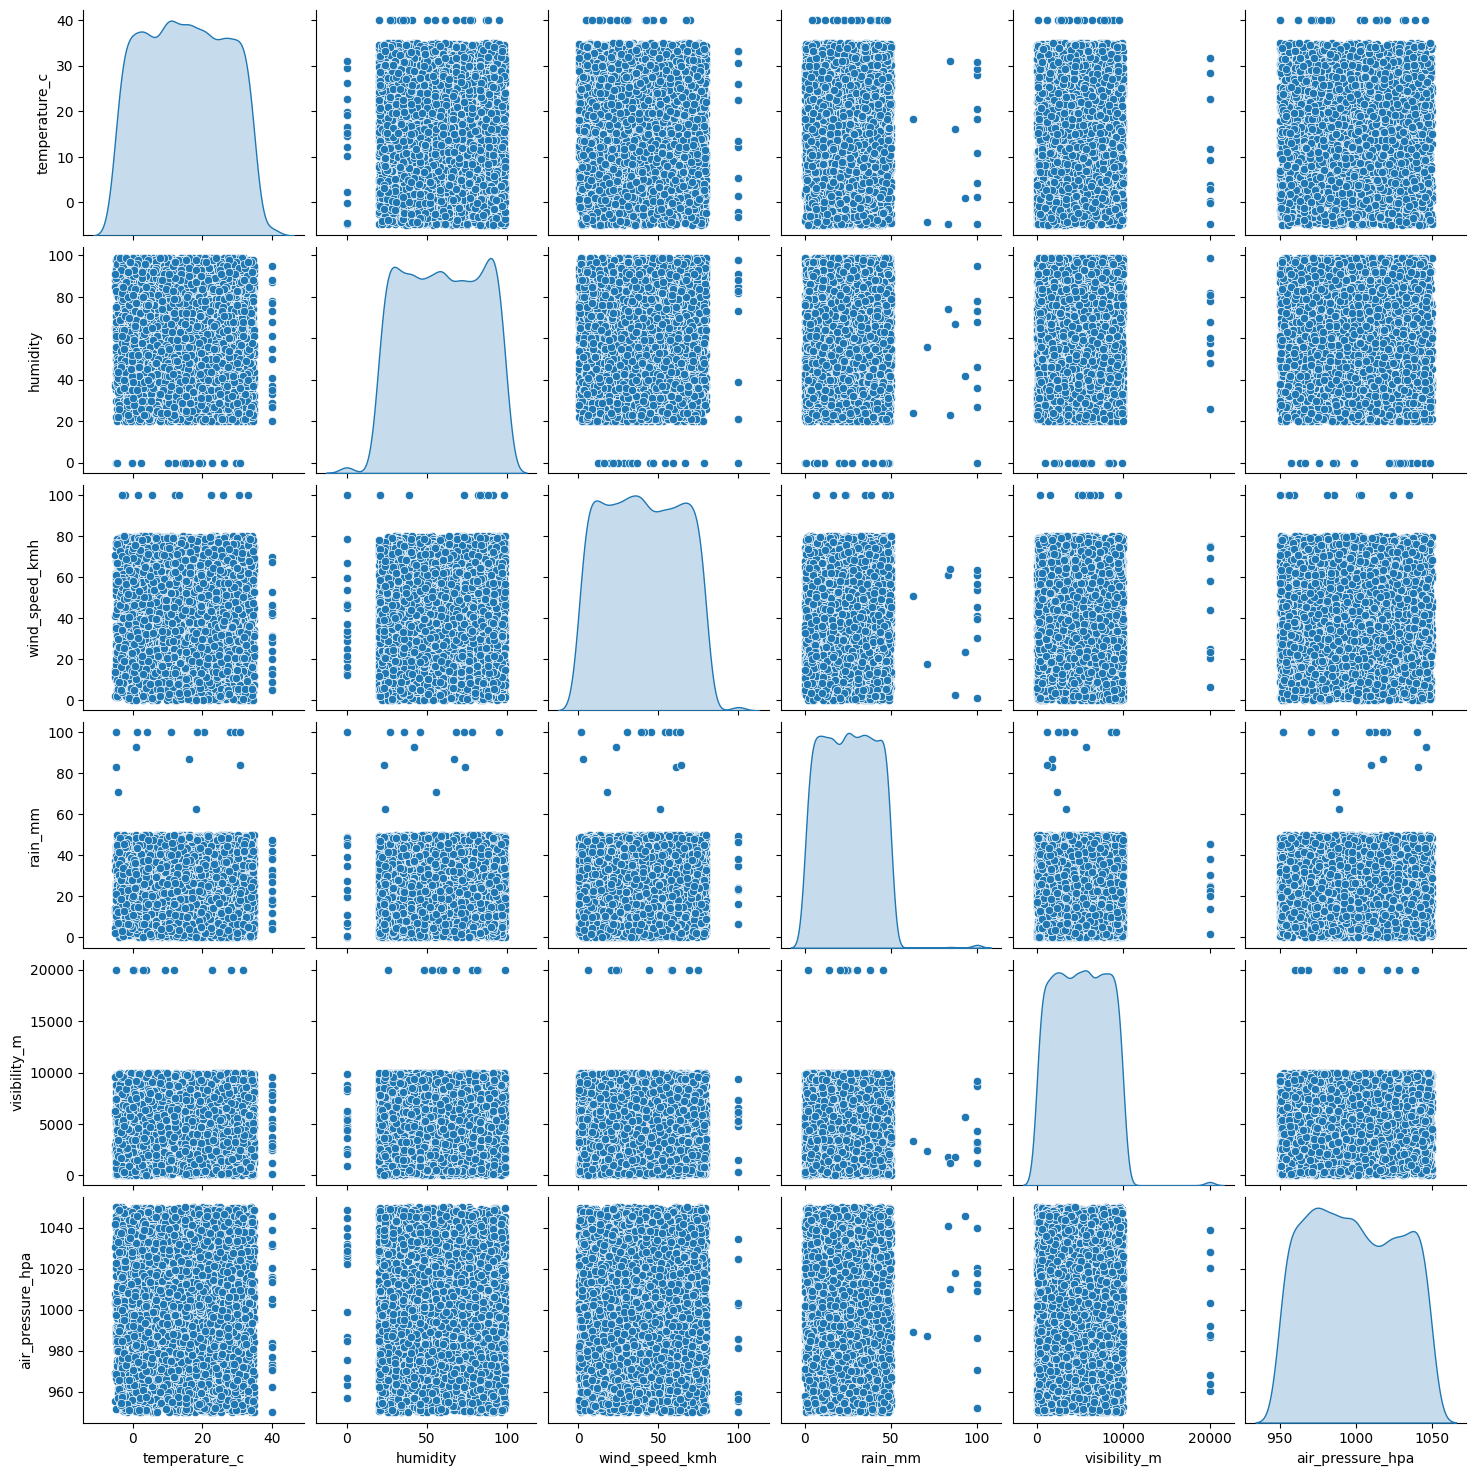

In [ ]:
fig = plt.figure(figsize=(10, 8))
sns.pairplot(weather_clean[numeric_weather_cols], diag_kind='kde')
plt.show()

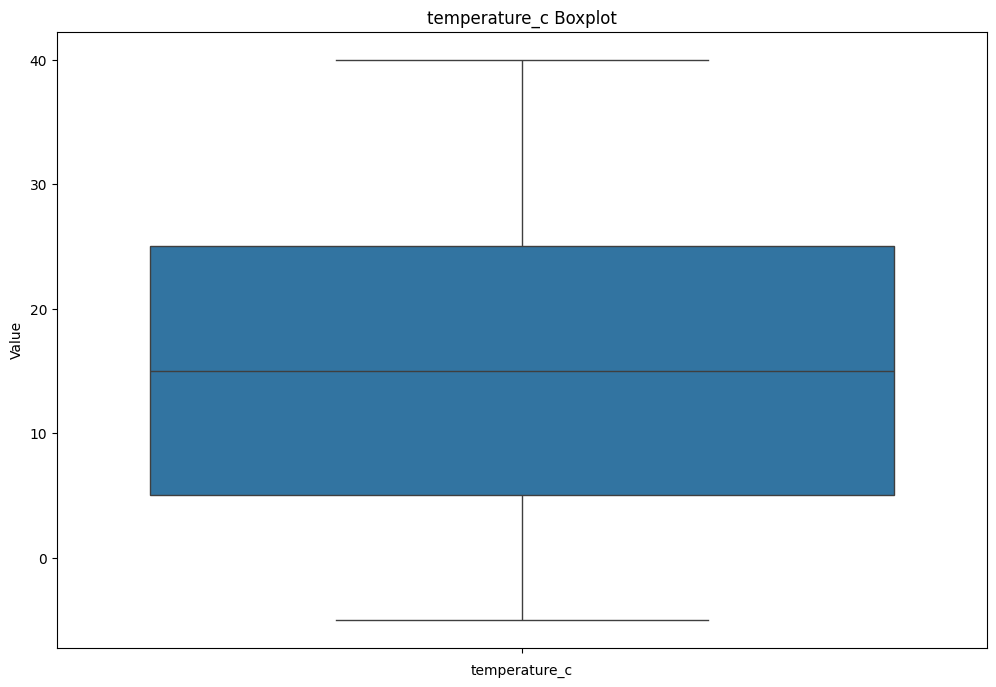

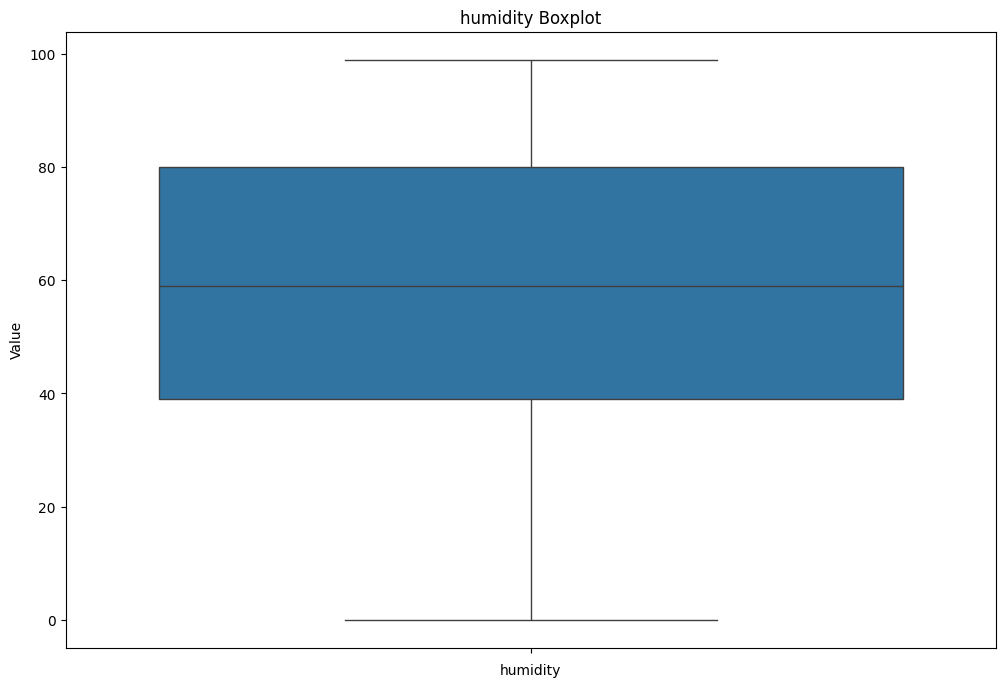

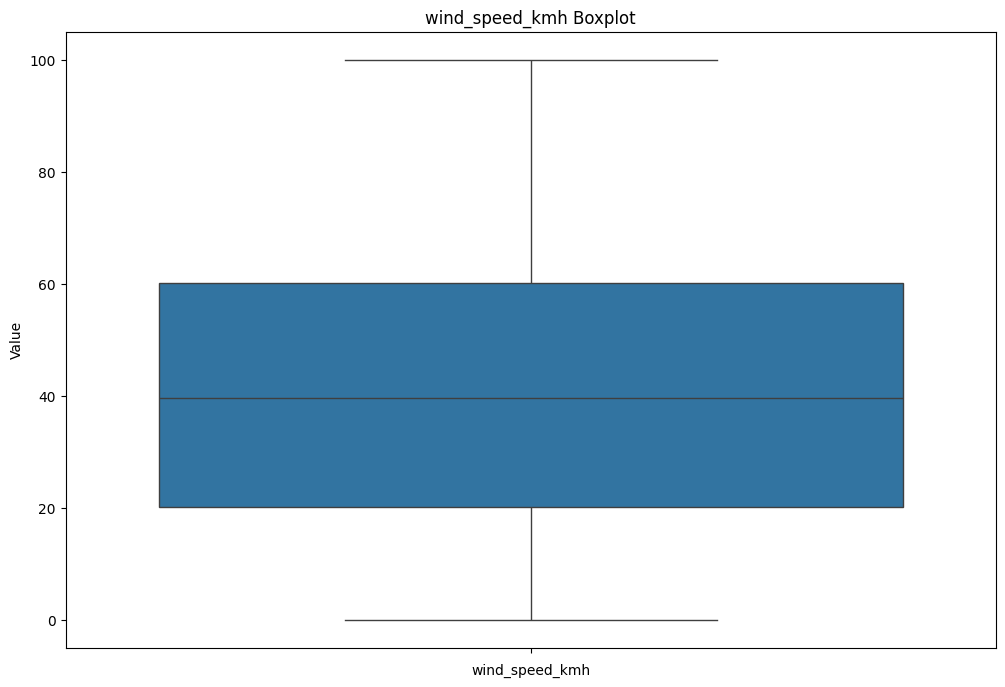

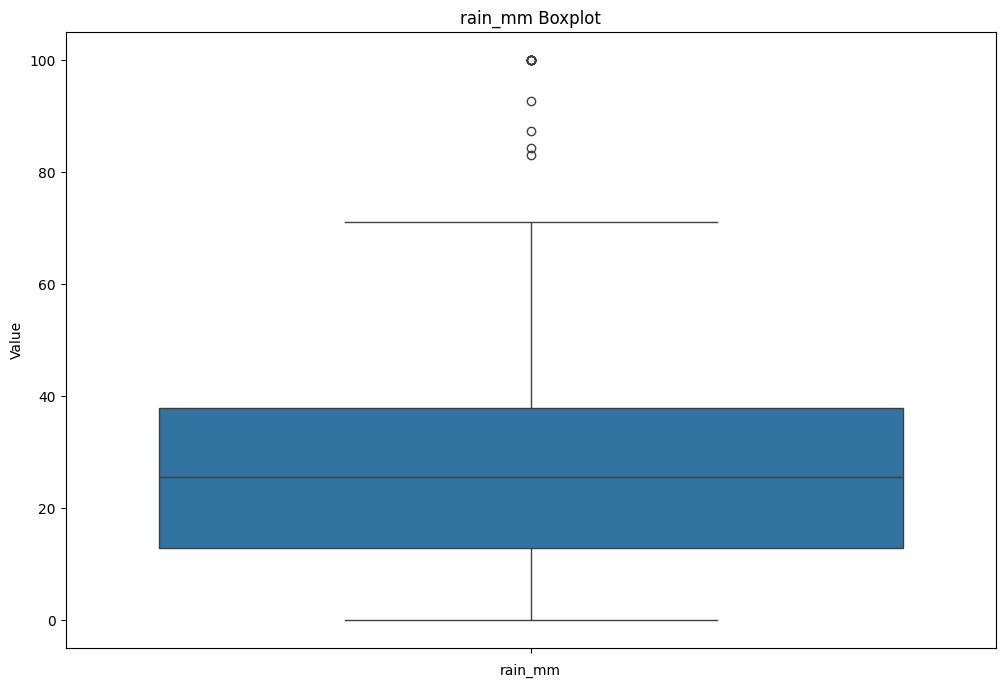

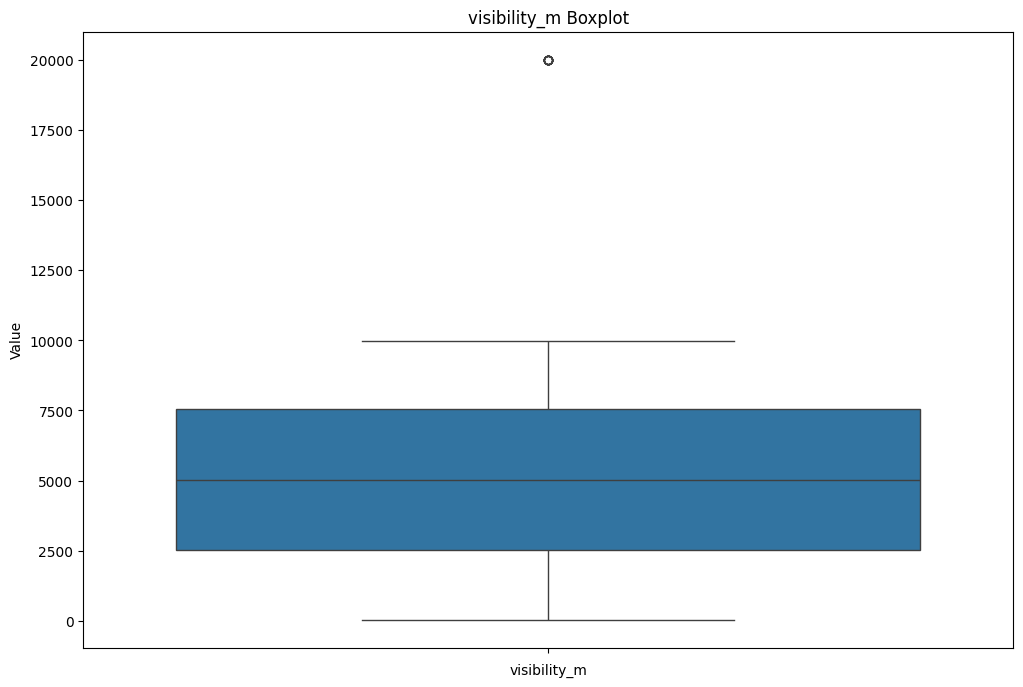

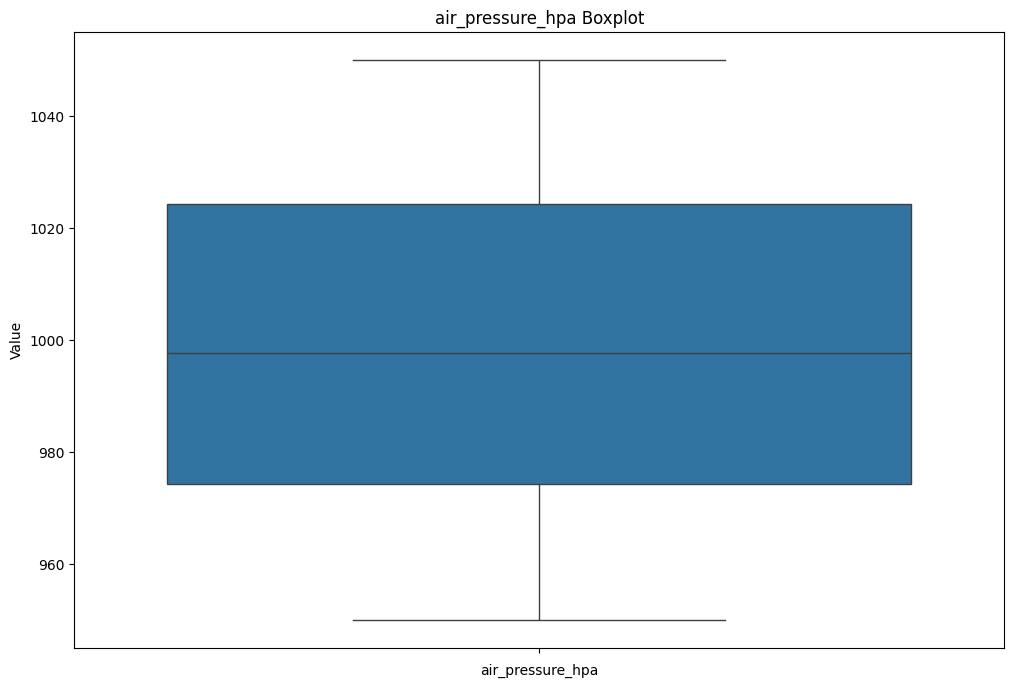

In [ ]:
for col in numeric_weather_cols:
    plt.figure(figsize=(12, 8))
    sns.boxplot(weather_clean[col])
    plt.title(f'{col} Boxplot')
    plt.xlabel(col)
    plt.ylabel('Value')
    plt.show()


In [ ]:
# Build a combined mask that keeps rows within the IQR bounds for ALL numeric_weather_cols
mask = pd.Series(True, index=weather_clean.index)

for col in numeric_weather_cols:
    # ensure column is numeric
    weather_clean[col] = pd.to_numeric(weather_clean[col], errors='coerce')
    Q1 = weather_clean[col].quantile(0.25)
    Q3 = weather_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = weather_clean[(weather_clean[col] < lower) | (weather_clean[col] > upper)]
    print(f"{col}: Found {len(outliers)} outliers")

    # update combined mask: keep only rows within bounds for this column
    mask &= weather_clean[col].between(lower, upper, inclusive='both')

rows_before = len(weather_clean)
weather_cleanII = weather_clean[mask].copy()
rows_after = len(weather_cleanII)
print(f"\nRemoved {rows_before - rows_after} rows in total by applying IQR filtering across columns")
print(f"Data shape after removing outliers: {weather_cleanII.shape}")
print(f"the lost of Data is: {(weather_df.shape[0]-weather_cleanII.shape[0])/weather_df.shape[0]}")

temperature_c: Found 0 outliers
humidity: Found 0 outliers
wind_speed_kmh: Found 0 outliers
rain_mm: Found 13 outliers
visibility_m: Found 10 outliers
air_pressure_hpa: Found 0 outliers

Removed 23 rows in total by applying IQR filtering across columns
Data shape after removing outliers: (4794, 11)
the lost of Data is: 0.050693069306930696


In [ ]:
numeric_traffic_col = traffic_clean.select_dtypes(include=['int', 'float'])

<Figure size 1000x800 with 0 Axes>

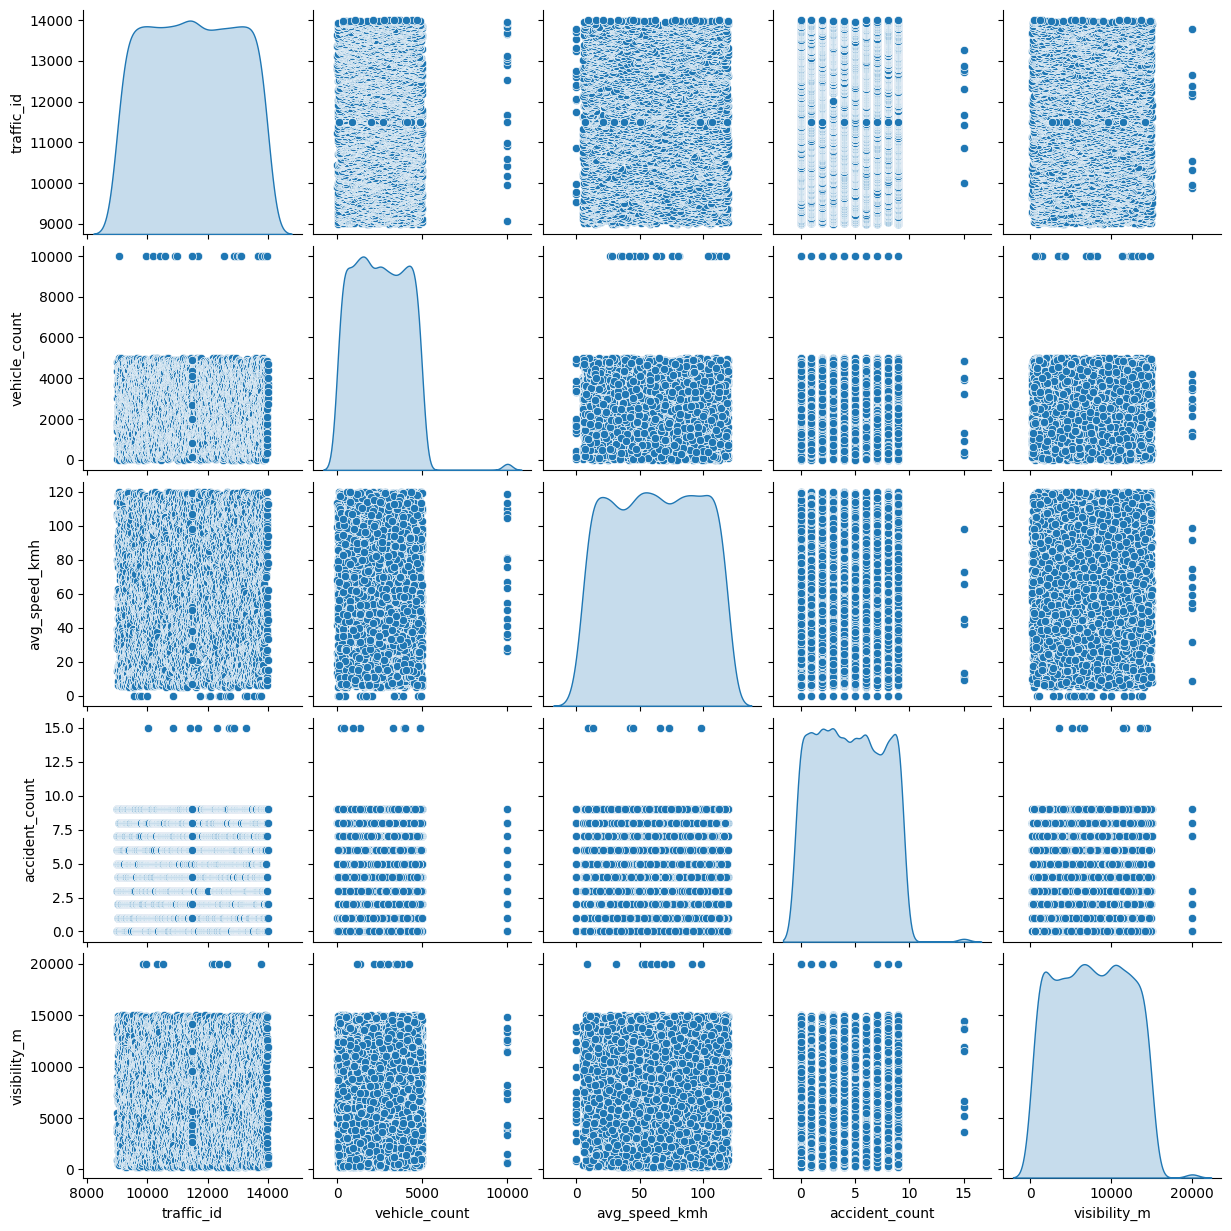

In [ ]:
fig = plt.figure(figsize=(10, 8))
sns.pairplot(numeric_traffic_col, diag_kind='kde')
plt.show()

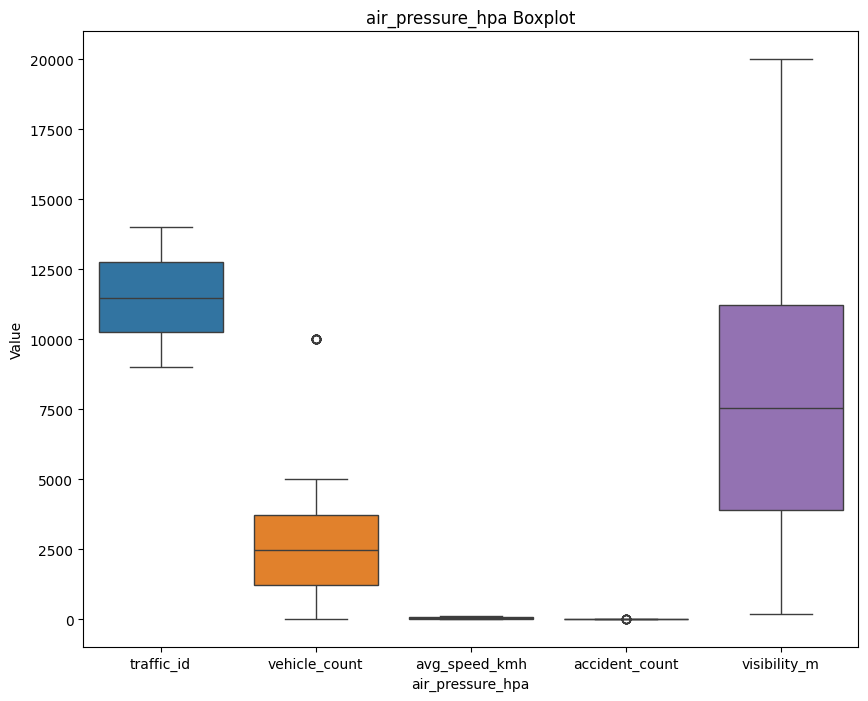

In [ ]:
    plt.figure(figsize=(10, 8))
    sns.boxplot(numeric_traffic_col)
    plt.title(f'{col} Boxplot')
    plt.xlabel(col)
    plt.ylabel('Value')
    plt.show()


In [ ]:
# Build a combined mask that keeps rows within the IQR bounds for ALL numeric_weather_cols
mask = pd.Series(True, index=traffic_clean.index)

for col in numeric_traffic_col.columns:
    # ensure column is numeric
    traffic_clean[col] = pd.to_numeric(traffic_clean[col], errors='coerce')
    Q1 = traffic_clean[col].quantile(0.25)
    Q3 = traffic_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = traffic_clean[(traffic_clean[col] < lower) | (traffic_clean[col] > upper)]
    print(f"{col}: Found {len(outliers)} outliers")

    # update combined mask: keep only rows within bounds for this column
    mask &= traffic_clean[col].between(lower, upper, inclusive='both')

rows_before = len(traffic_clean)
traffic_cleanII = traffic_clean[mask].copy()
rows_after = len(traffic_cleanII)
print(f"\nRemoved {rows_before - rows_after} rows in total by applying IQR filtering across columns")
print(f"Data shape after removing outliers: {traffic_cleanII.shape}")
print(f"the lost of Data is: {(traffic_df.shape[0]-traffic_cleanII.shape[0])/traffic_df.shape[0]}")

traffic_id: Found 0 outliers
vehicle_count: Found 20 outliers
avg_speed_kmh: Found 0 outliers
accident_count: Found 9 outliers
visibility_m: Found 0 outliers

Removed 29 rows in total by applying IQR filtering across columns
Data shape after removing outliers: (4813, 10)
the lost of Data is: 0.04503968253968254


## 6. Save Cleaned Data


In [ ]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Save cleaned datasets
weather_cleanII.to_parquet('Data/weather_cleaned.parquet', index=False)
traffic_cleanII.to_parquet('Data/traffic_cleaned.parquet', index=False)

print("Cleaned data saved successfully!")
print(f"  - weather_cleaned.parquet: {len(weather_cleanII)} rows")
print(f"  - traffic_cleaned.parquet: {len(traffic_cleanII)} rows")

Cleaned data saved successfully!
  - weather_cleaned.parquet: 4794 rows
  - traffic_cleaned.parquet: 4813 rows
